In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
noisysine = pd.read_csv('noisysine.csv')
noisysine.head()

,x,y
0,0,0.35552
1,1,0.51179
2,2,1.08470
3,3,0.91980
4,4,1.18920


In [3]:
hydrodynamics = pd.read_csv('hydrodynamics.csv')
hydrodynamics.head()

,x0,x1,x2,x3,x4,x5,y
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


# Linear Regression without regularization

In [4]:
class LinearRegression():
    def __init__(self, deg=1, alpha=0):
        self.__transformer = PolynomialFeatures(degree=deg)
        self.w = None
        self.alpha = alpha
    
    def fit(self, X, y):
        X_poly = self.__transformer.fit_transform(X)
        if self.alpha == 0:
            self.w = np.linalg.pinv(X_poly) @ y
        else:
            self.w = np.linalg.inv(X_poly.T @ X_poly + self.alpha * np.eye(X_poly.shape[1])) \
                    @ X_poly.T @ y
        
    def predict(self, X):
        X_poly = self.__transformer.fit_transform(X)
        y_pred = X_poly @ self.w
        return y_pred

In [5]:
def visualize_regression(linreg, X, y, model_name, X_train, y_train):
    pred = linreg.predict(X)
    rscore = r2_score(y, pred)
    print(f'R2-score: {rscore}')
    
    plt.scatter(X, y, c='pink')
    plt.scatter(X_train, y_train)
    plt.legend(['Val', 'Train'])
    x_plot = np.linspace(min(min(X_train), min(X)), 
                         max(max(X_train), max(X)),
                         30)
    y_plot = linreg.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, c='r')
    plt.title(f'{model_name}')
    plt.show()

In [9]:
sin_X_train, sin_X_val, sin_y_train, sin_y_val = train_test_split(noisysine.x.values,
                                                                  noisysine.y.values,
                                                                  test_size=0.2,
                                                                  shuffle=True)

In [10]:
sin_lr_1 = LinearRegression()
sin_lr_1.fit(sin_X_train.reshape(-1, 1), sin_y_train)

## Noisysine

R2-score: 0.16249860619689038


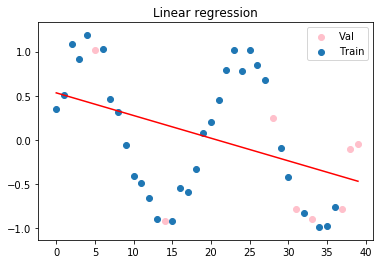

In [11]:
visualize_regression(sin_lr_1, sin_X_val.reshape(-1, 1), sin_y_val, 'Linear regression',
                     sin_X_train, sin_y_train)

R2-score: 0.14883916996882762


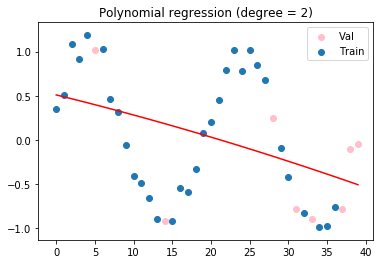

------------------------------------------------
R2-score: -2.6395022672155823


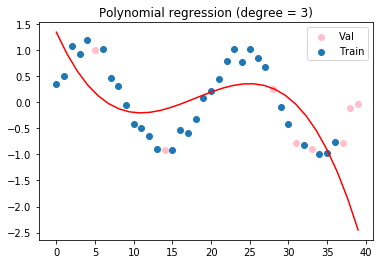

------------------------------------------------
R2-score: -7.9963370041992565


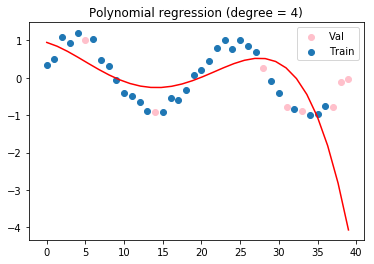

------------------------------------------------
R2-score: -1.5204619412158724


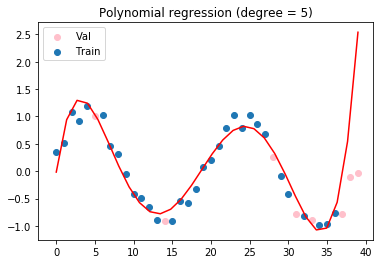

------------------------------------------------


In [12]:
for d in range(2, 6):
    model = LinearRegression(deg=d)
    model.fit(sin_X_train.reshape(-1, 1), sin_y_train)
    visualize_regression(model, sin_X_val.reshape(-1, 1), sin_y_val, f'Polynomial regression (degree = {d})',
                         sin_X_train, sin_y_train)
    print('------------------------------------------------')

In [13]:
hydro_x_train, hydro_x_val, hydro_y_train, hydro_y_val = train_test_split(hydrodynamics.drop(columns=['y']).values,
                                                                          hydrodynamics.y.values,
                                                                          test_size=0.2,
                                                                          shuffle=True)

In [14]:
linreg_hydro = LinearRegression()
linreg_hydro.fit(hydro_x_train, hydro_y_train)

In [15]:
polyreg_hydro = LinearRegression(deg=2)
polyreg_hydro.fit(hydro_x_train, hydro_y_train)

## Hydrodynamics

In [16]:
lin_pred = linreg_hydro.predict(hydro_x_val)
poly_pred = polyreg_hydro.predict(hydro_x_val)
print(f'R2-score (linear regression): {r2_score(hydro_y_val, lin_pred)}')
print(f'R2-score (polynomial regression, degree=2): {r2_score(hydro_y_val, poly_pred)}')

R2-score (linear regression): 0.7059208332453314
R2-score (polynomial regression, degree=2): 0.9295594815503847


# Linear Regression with regularization

In [17]:
def find_optimal_reg(deg, X_train, X_val, y_train, y_val, plot=False):
    alpha_prev = 0
    m = LinearRegression(deg=deg, alpha=alpha_prev)
    m.fit(X_train, y_train)
    prev_score = r2_score(y_val, m.predict(X_val))
    for alpha in np.linspace(0.01, 10, 100):
        m = LinearRegression(deg=deg, alpha=alpha)
        m.fit(X_train, y_train)
        score = r2_score(y_val, m.predict(X_val))
        if score > prev_score:
            alpha_prev = alpha
            prev_score = score
            
    print(f'Optimal regularization parameter for deg={deg}: {alpha_prev}')
    if plot:
        m = LinearRegression(deg=deg, alpha=alpha_prev)
        m.fit(X_train, y_train)
        visualize_regression(m, X_val, y_val, f'Polynomial Regression (deg={deg}, reg={round(alpha_prev, 3)})',
                             X_train, y_train)
    else:
        print(f'Max r2-score: {prev_score}')

## Noisysine

Optimal regularization parameter for deg=1: 0
R2-score: 0.16249860619689038


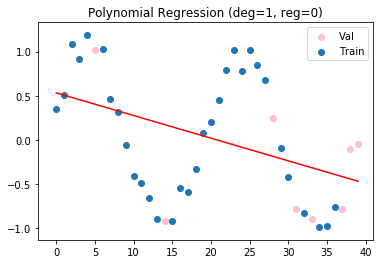

------------------------------------------------
Optimal regularization parameter for deg=2: 0
R2-score: 0.14883916996882762


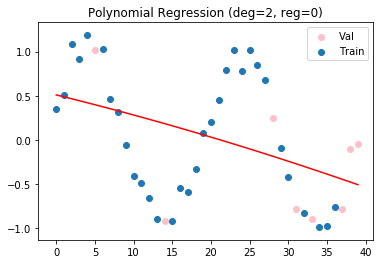

------------------------------------------------
Optimal regularization parameter for deg=3: 10.0
R2-score: -1.4528578872579394


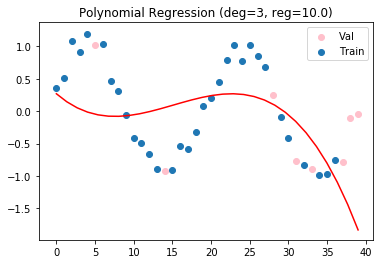

------------------------------------------------
Optimal regularization parameter for deg=4: 0
R2-score: -7.9963370041992565


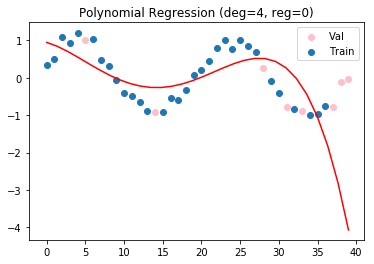

------------------------------------------------
Optimal regularization parameter for deg=5: 8.183636363636364
R2-score: 0.7342059288996845


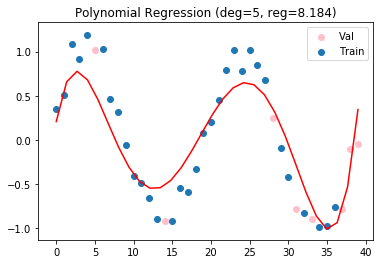

------------------------------------------------


In [18]:
for d in range(1, 6):
    find_optimal_reg(d, sin_X_train.reshape(-1, 1), sin_X_val.reshape(-1, 1), sin_y_train, sin_y_val, plot=True)
    print('------------------------------------------------')

## Hydrodynamics

In [19]:
find_optimal_reg(1, hydro_x_train, hydro_x_val, hydro_y_train, hydro_y_val)
print()
find_optimal_reg(2, hydro_x_train, hydro_x_val, hydro_y_train, hydro_y_val)

Optimal regularization parameter for deg=1: 0
Max r2-score: 0.7059208332453314

Optimal regularization parameter for deg=2: 0
Max r2-score: 0.9295594815503847


# LASSO regularization

In [20]:
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

In [21]:
def find_optimal_reg_sklearn(deg, X_train, X_val, y_train, y_val, plot=False):
    alpha_prev = 0
    X_train_poly = PolynomialFeatures(degree=deg).fit_transform(X_train)
    X_val_poly = PolynomialFeatures(degree=deg).fit_transform(X_val)
    m = Lasso(alpha=alpha_prev).fit(X_train_poly, y_train)
    prev_score = r2_score(y_val, m.predict(X_val_poly))
    
    
    for alpha in np.linspace(0.01, 10, 200):
        m = Lasso(alpha=alpha).fit(X_train_poly, y_train)
        score = r2_score(y_val, m.predict(X_val_poly))
        if score > prev_score:
            alpha_prev = alpha
            prev_score = score
            
    print(f'Optimal regularization parameter for deg={deg}: {alpha_prev}')
    m = Lasso(alpha=alpha_prev).fit(X_train_poly, y_train)
    print(f'Number of features left: {np.count_nonzero(m.coef_)}')
    if plot:
        visualize_regression_sklearn(m, X_val, y_val, 
                                     f'Polynomial Regression with LASSO (deg={deg}, reg={round(alpha_prev, 3)})',
                                     X_train, y_train, deg)
    else:
        print(f'Max r2-score: {prev_score}')

In [22]:
def visualize_regression_sklearn(linreg, X, y, model_name, X_train, y_train, deg):
    pred = linreg.predict(PolynomialFeatures(degree=deg).fit_transform(X))
    rscore = r2_score(y, pred)
    print(f'R2-score: {rscore}')
    
    plt.scatter(X, y, c='pink')
    plt.scatter(X_train, y_train)
    plt.legend(['Val', 'Train'])
    x_plot = np.linspace(min(min(X_train), min(X)), 
                         max(max(X_train), max(X)),
                         30)
    y_plot = linreg.predict(PolynomialFeatures(degree=deg).fit_transform(x_plot.reshape(-1, 1)))
    plt.plot(x_plot, y_plot, c='r')
    plt.title(f'{model_name}')
    plt.show()

Optimal regularization parameter for deg=1: 0
Number of features left: 1
R2-score: 0.1624986061968905


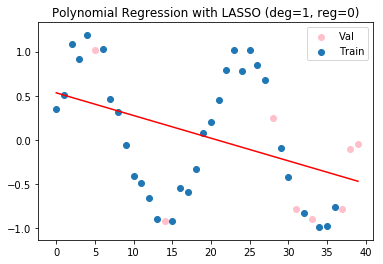

------------------------------------------------
Optimal regularization parameter for deg=2: 0
Number of features left: 2
R2-score: 0.14883916996882673


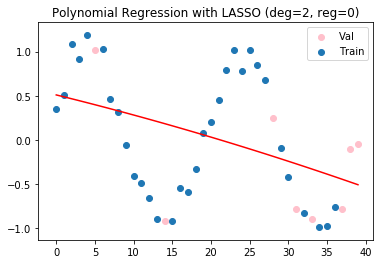

------------------------------------------------
Optimal regularization parameter for deg=3: 10.0
Number of features left: 1
R2-score: -0.1234669801360826


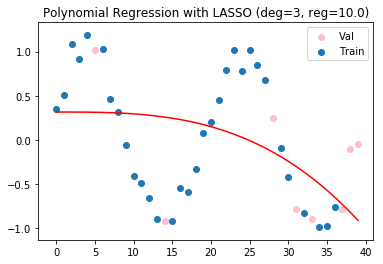

------------------------------------------------
Optimal regularization parameter for deg=4: 10.0
Number of features left: 2
R2-score: -1.5436547632102888


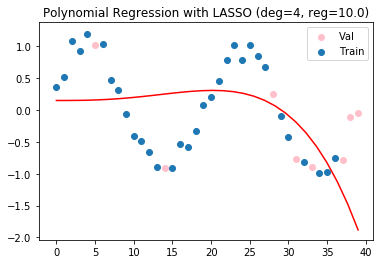

------------------------------------------------
Optimal regularization parameter for deg=5: 9.548190954773869
Number of features left: 3
R2-score: -3.266055863452931


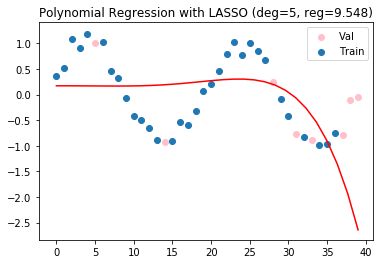

------------------------------------------------


In [24]:
for d in range(1, 6):
    find_optimal_reg_sklearn(d, sin_X_train.reshape(-1, 1), sin_X_val.reshape(-1, 1), sin_y_train, sin_y_val, plot=True)
    print('------------------------------------------------')

In [25]:
find_optimal_reg_sklearn(1, hydro_x_train, hydro_x_val, hydro_y_train, hydro_y_val)
print()
find_optimal_reg_sklearn(2, hydro_x_train, hydro_x_val, hydro_y_train, hydro_y_val)

Optimal regularization parameter for deg=1: 0.01
Number of features left: 5
Max r2-score: 0.7090565812423488

Optimal regularization parameter for deg=2: 0.01
Number of features left: 13
Max r2-score: 0.936286579357795
